In [1]:
from __future__ import division, print_function, absolute_import
import pandas as pd
from glob import glob
import fnmatch
import cv2
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from sklearn.utils import class_weight
#Import tflearn and some helpers
import os,sys,time,signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import numpy as np
import tensorflow as tf
import datetime as dt
import tflearn
from tensorflow import keras
import keras.utils
from tflearn.data_utils import shuffle
from keras import utils as np_utils
from keras.utils.np_utils import to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.merge_ops import merge
from tflearn.layers.estimator import regression
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential, model_from_json,load_model,Model
from tensorflow.keras import layers
from tensorflow.keras import Model
#import seaborn as sns


Using TensorFlow backend.


In [2]:
#####1. 数据处理读入整理增强#####

# 1)read data /the dataset has already been marked as class0=no cancer and class1=has cancer

image = glob( '../his/**/*.png',recursive=True)
#image = glob( '../dataImg/*/**/*.png',recursive=True)
lowerIndex=0
upperIndex = len(image)
class0 = '../his/0/*.png'
class1 = '../his/1/*.png'
classZero = fnmatch.filter(image, class0)
classOne = fnmatch.filter(image, class1)
#print(classZero)

def process_images(lowerIndex,upperIndex):
	X = []
	Y = []
	WIDTH=53
	HEIGHT=80

	for img in image[lowerIndex:upperIndex]:
		full_size_image = cv2.imread(img)
		X.append(cv2.resize(full_size_image, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC))
		if img in classZero:
			Y.append(0)
		elif img in classOne:
			Y.append(1)
		else: 
			return
	return X, Y

X,Y = process_images(0,upperIndex)

In [3]:
df = pd.DataFrame(image)#load the dataset as a panda dataframe
df["images"]=X
df["labels"]=Y

X=np.array(X)

In [4]:
# 2)split training validating sets 分开训练集与验证集
#train and validation split https://stackoverflow.com/questions/43038750/how-can-i-test-my-convolutional-neural-network-code-with-anomaly-images
X_train, X_val, y_train, y_val =train_test_split(X, Y,test_size=0.20,  random_state=42)
#X_tra# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=6)
#X_train.astype('float32')
#X_test= X_test.astype('float32')
print("X_train.shape",X_train.shape)
print("X_test.shape",X_test.shape)
print("X_val.shape",X_val.shape)

X_train.shape (1449, 80, 53, 3)
X_test.shape (161, 80, 53, 3)
X_val.shape (403, 80, 53, 3)


In [5]:
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)
y_valHot = to_categorical(y_val, num_classes = 2)

distribution=df['labels'].value_counts()
print(distribution)
print("Total benign samples:",len(classZero))
print("Total malignant samples:",len(classOne))
print("Total sample amount: ", upperIndex)
print("Total train samples (=72% of total sample size):",len(X_train))
print("Total test samples (=8% of total sample size):",len(X_test))
print("Total validation samples (=20% of total sample size):",len(X_val))

1    1390
0     623
Name: labels, dtype: int64
Total benign samples: 623
Total malignant samples: 1390
Total sample amount:  2013
Total train samples (=72% of total sample size): 1449
Total test samples (=8% of total sample size): 161
Total validation samples (=20% of total sample size): 403


In [6]:
from tensorflow.keras import layers
img_input = layers.Input(shape=(80, 53, 3))


# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
#x = layers.Conv2D(16, 3, activation='relu')(img_input)
#x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

 #Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation

# Create output layer with a single node and sigmoid activation
output = layers.Dense(2, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 53, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 51, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 23, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12672)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               6488576   
__________

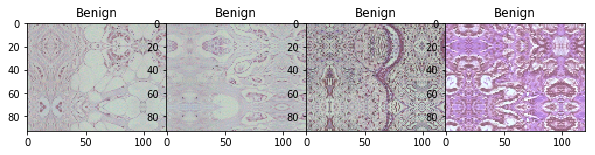

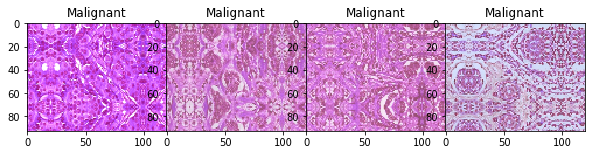

In [7]:
plotImages=classZero
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in plotImages[:4]:
	im = cv2.imread(l)
	im = cv2.resize(im, (80, 53)) 
	color=[255,255,255]
	new_im = cv2.copyMakeBorder(im,20,20, 20,20, 20,
    value=color)
	plt.subplot(1, 4, i_+1).set_title("Benign")
	plt.imshow(new_im); plt.axis('on')
	i_ += 1
plt.show()

plotImages=classOne
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in plotImages[:4]:
	im = cv2.imread(l)
	im = cv2.resize(im, (80, 53)) 
	color=[255,255,255]
	new_im = cv2.copyMakeBorder(im,20,20, 20,20, 20,
    value=color)
	plt.subplot(1, 4, i_+1).set_title("Malignant")
	plt.imshow(new_im); plt.axis('on')
	i_ += 1
plt.show()

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2
)
a = X_train
b = y_trainHot
c = X_val
d = y_valHot
e = X_test
f= y_testHot
#print (len(a))
#print (len(d))

history = model.fit_generator(
	datagen.flow(a,b, batch_size=50), 
    steps_per_epoch=len(a)/32, 
    epochs=15,
    verbose=1,
    validation_data=[c, d])


Epoch 1/15
46/45 [==============================] - 15s 325ms/step - loss: 0.5597 - acc: 0.7106 - val_loss: 2.1295 - val_acc: 0.8548
Epoch 2/15
46/45 [==============================] - 15s 316ms/step - loss: 0.4841 - acc: 0.7942 - val_loss: 2.0754 - val_acc: 0.8610
Epoch 3/15
46/45 [==============================] - 15s 321ms/step - loss: 0.4561 - acc: 0.8340 - val_loss: 2.0497 - val_acc: 0.8672
Epoch 4/15
46/45 [==============================] - 15s 318ms/step - loss: 0.4490 - acc: 0.8360 - val_loss: 2.0785 - val_acc: 0.8648
Epoch 5/15
46/45 [==============================] - 15s 328ms/step - loss: 0.4313 - acc: 0.8451 - val_loss: 2.2000 - val_acc: 0.8586
Epoch 6/15
46/45 [==============================] - 15s 333ms/step - loss: 0.4208 - acc: 0.8512 - val_loss: 2.2264 - val_acc: 0.8573
Epoch 7/15
46/45 [==============================] - 15s 330ms/step - loss: 0.4187 - acc: 0.8455 - val_loss: 3.1135 - val_acc: 0.8002
Epoch 8/15
46/45 [==============================] - 15s 322ms/step - 

In [10]:
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score,classification_report
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score,auc,roc_curve

map_characters = {0: '0', 1: '1'}
y_pred = model.predict(X_test)
#print(len(y_pred))
#print(len(y_testHot))
y_pred_classes = np.argmax(y_pred, axis=1)
print('\n', sklearn.metrics.classification_report(np.where(f > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
auc = roc_auc_score(y_testHot, y_pred)
print("AUC=",auc)


              precision    recall  f1-score   support

           0       0.86      0.45      0.59        53
           1       0.78      0.96      0.86       108

   micro avg       0.80      0.80      0.80       161
   macro avg       0.82      0.71      0.73       161
weighted avg       0.81      0.80      0.77       161

AUC= 0.7255415793151643


Testing sample size: 161


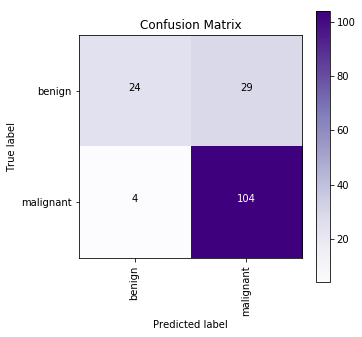

Normalized Confusion matrix
[[0.45 0.55]
 [0.04 0.96]]


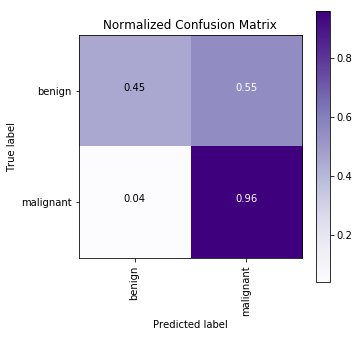

In [11]:
import itertools
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score,classification_report

def plot_confusion_matrix(cm, classes,
                          normalize,
                          title,
                          cmap=plt.cm.Purples):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1) 
y_true = np.argmax(f,axis=1)
class_categories = {0: 'benign', 1: 'malignant'}

### not normalized  ###

cm = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(cm, title="Confusion Matrix", normalize=False,classes = list(class_categories.values())) 
print("Testing sample size:", len(y_test))
plt.show()

###normalized ###

#normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion matrix")
print (cm_normalized.round(2))
cm_normalized=cm_normalized.round(2)
plot_confusion_matrix(cm_normalized, title="Normalized Confusion Matrix", normalize=True,classes = list(class_categories.values())) 
plt.show()



Text(0.5, 1.0, 'Training and validation loss')

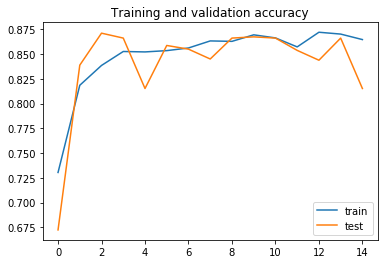

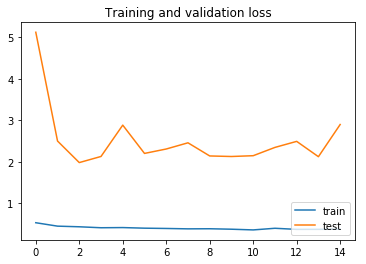

In [12]:
#Evaluating accuracy and loss for the model

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.figure(figsize=(6,4))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(['train', 'test'], loc='lower right')
plt.title('Training and validation accuracy')

plt.figure(figsize=(6,4))

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['train', 'test'], loc='lower right')
plt.title('Training and validation loss')

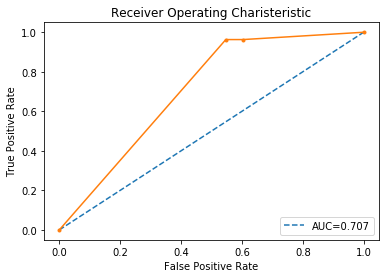

In [13]:
#youtube:5.1: Binary Classification, ROC, AUC for Deep Learning, TensorFlow and Keras (Module 5, Part 1)
#link:https://www.youtube.com/watch?time_continue=945&v=9abzk34U56c

#pred=model.predict(X_test)
#pred=ng.argmax(pred, axis=1) 上面定义的
#Y_compare=np.argmax(Y_test, axis=1)
#youtube

##pred=model.predict(X_test)#in our code called as y_pred
##pred=pred[:,1] #only positive values
##plot_roc(pred, y_compare)

#blog How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python
#bloglink https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

y_pred = model.predict(X_test)
y_pred=y_pred[:,1]#only positive cases
# calculate AUC
auc = roc_auc_score(y_test, y_pred)
#print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(6,4))

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charisteristic')
plt.legend(['AUC=%.3f'%auc],loc='lower right')
# show the plot
pyplot.show()